<a href="https://colab.research.google.com/github/khoji-code/Data-Analysis/blob/main/Human_Activity_Recognition_(HAR)_with_Smartphone_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Activity Recognition (HAR) with Smartphone Data

### **Project Overview**

* **Goal:** To build a machine learning model capable of accurately classifying human activities (e.g., Walking, Sitting, Standing) using sensor data from smartphones.
* **Dataset:** The project utilizes the UCI Human Activity Recognition (HAR) dataset, containing pre-processed time-series data from accelerometer and gyroscope sensors.
* **Methodology:** The analysis includes an advanced exploratory data analysis (EDA) using t-SNE to visualize high-dimensional data. Features are scaled using `StandardScaler`, and two models, Logistic Regression and XGBoost, are trained and evaluated.
* **Key Result:** The XGBoost model demonstrates high performance, achieving an accuracy of **92,57%** on the test set. The confusion matrix shows strong differentiation between static and dynamic activities.

***

### **Purpose**

* **Develop a High-Accuracy Classifier:** To build and validate a robust model for classifying human activities, which has significant real-world applications.
* **Enable Context-Aware Technology:** To provide a foundation for applications that can automatically detect a user's physical state, such as fitness tracking, healthcare monitoring, and smart home adjustments.
* **Benchmark Model Performance:** To compare the effectiveness of a simpler model (Logistic Regression) against an advanced gradient boosting model (XGBoost) for this specific classification task.

### Dataset:
https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

## IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import warnings

# Ignore warnings for a cleaner output.
warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

Libraries imported successfully.


## LOAD AND PREPARE DATA

In [3]:
try:
    # --- Load Feature Data ---
    # Explain: `read_csv` with `delim_whitespace=True` handles space-separated data. `header=None` is used
    # because the files do not contain column names.
    X_train = pd.read_csv('/content/drive/MyDrive/Human Activity/Human Activity Recognition Using Smartphones/X_train.txt', delim_whitespace=True, header=None)
    X_test = pd.read_csv('/content/drive/MyDrive/Human Activity/Human Activity Recognition Using Smartphones/X_test.txt', delim_whitespace=True, header=None)

    # --- Load Labels ---
    y_train = pd.read_csv('/content/drive/MyDrive/Human Activity/Human Activity Recognition Using Smartphones/y_train.txt', header=None, names=['activity_id'])
    y_test = pd.read_csv('/content/drive/MyDrive/Human Activity/Human Activity Recognition Using Smartphones/y_test.txt', header=None, names=['activity_id'])

    # --- Load Feature and Activity Names ---
    features = pd.read_csv('/content/drive/MyDrive/Human Activity/Human Activity Recognition Using Smartphones/features.txt', delim_whitespace=True, header=None, names=['feature_id', 'feature_name'])
    activity_labels = pd.read_csv('/content/drive/MyDrive/Human Activity/Human Activity Recognition Using Smartphones/activity_labels.txt', delim_whitespace=True, header=None, names=['activity_id', 'activity_name'])

    print("All data files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading data files: {e}")
    print("Please ensure all 6 required text files are uploaded to your Colab environment.")
    exit()


All data files loaded successfully.


In [5]:
# Assign Feature Names
# feature names from 'features.txt'
X_train.columns = features['feature_name']
X_test.columns = features['feature_name']

# Map Activity IDs to Names
y_train['activity_name'] = y_train['activity_id'].map(activity_labels.set_index('activity_id')['activity_name'])
y_test['activity_name'] = y_test['activity_id'].map(activity_labels.set_index('activity_id')['activity_name'])

print("\nData prepared and columns named.")
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Data prepared and columns named.
Training data shape: (7352, 561)
Test data shape: (2947, 561)


## EXPLORATORY DATA ANALYSIS (EDA)

### t-SNE Visualization

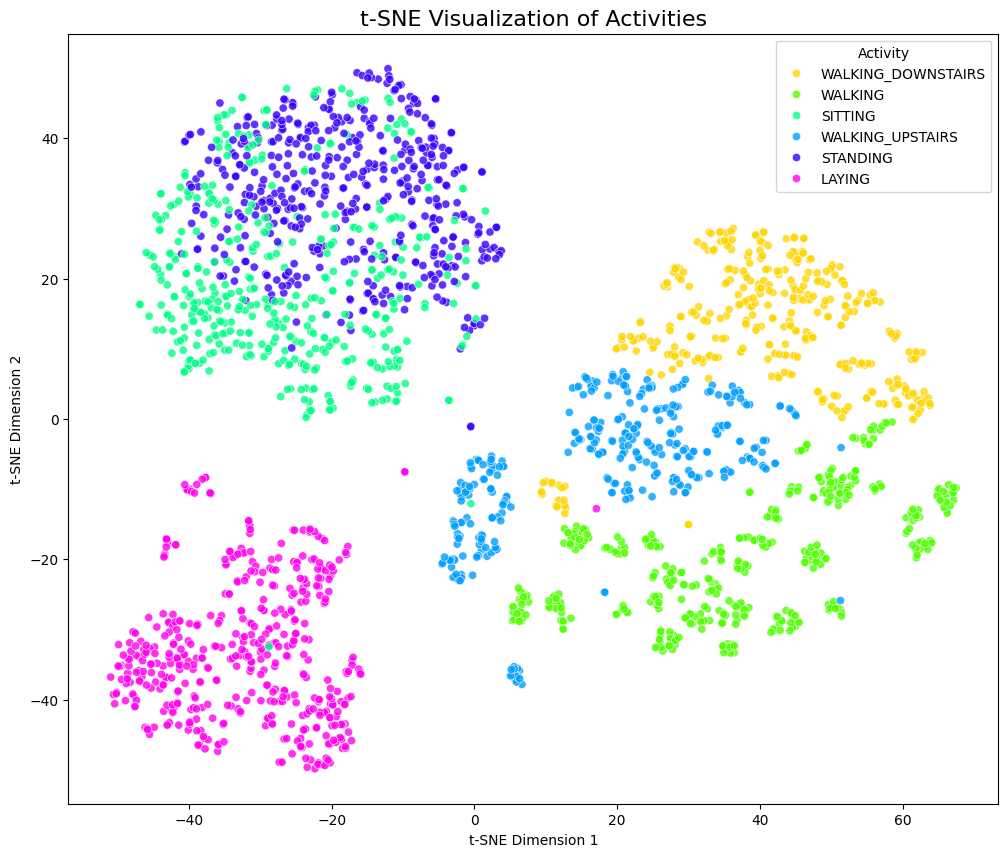

In [6]:
# reduce the 561 features to just 2 dimensions for plotting
# take a sample of the data to speed up the t-SNE process
sample_size = 2500
X_sample = X_train.sample(n=sample_size, random_state=42)
y_sample = y_train.loc[X_sample.index]

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(X_sample)

# Explain: Create a scatter plot of the t-SNE results, coloring each point by its activity.
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1],
    hue=y_sample['activity_name'],
    palette=sns.color_palette("hsv", 6),
    legend="full",
    alpha=0.8
)
plt.title('t-SNE Visualization of Activities', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Activity')
plt.show()

### Feature Importance by Sensor Type

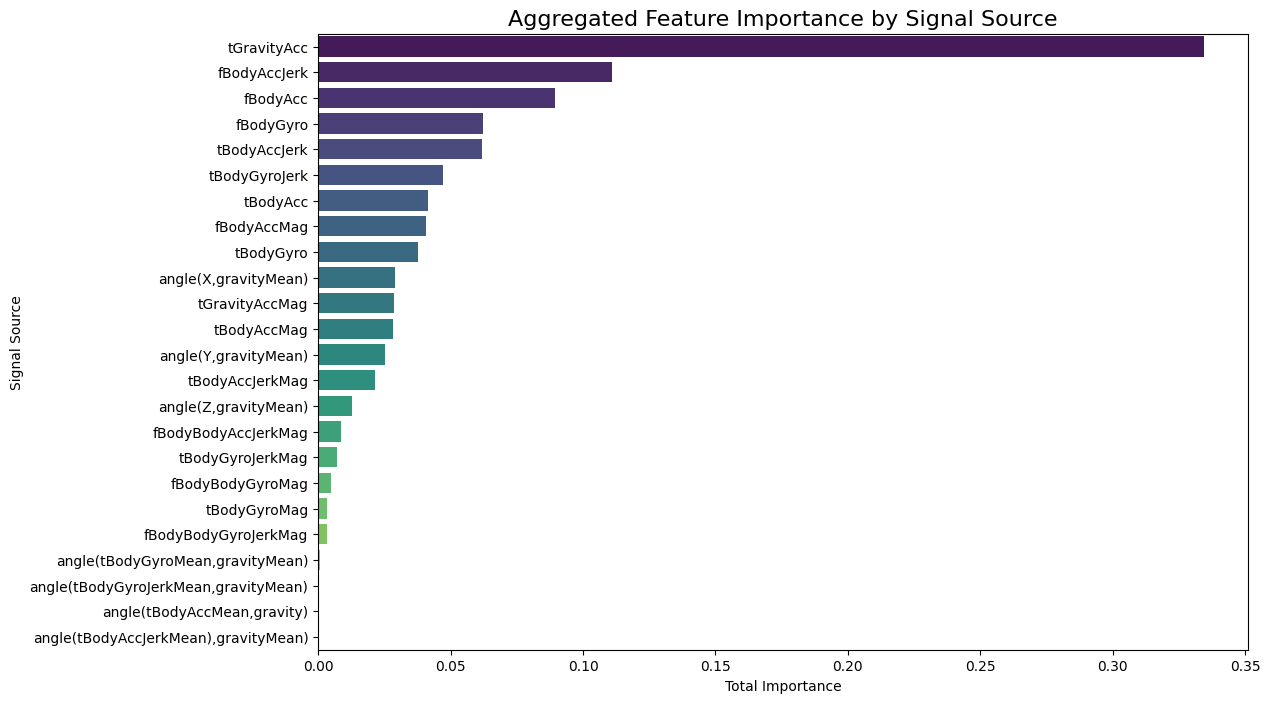

In [8]:
# To understand which types of sensor signals are most useful, we first train a
# quick Random Forest model to get feature importances.
temp_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
temp_model.fit(X_train, y_train['activity_id'])

importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': temp_model.feature_importances_
}).sort_values('importance', ascending=False)

# group these importances by signal source
importances['source'] = importances['feature'].apply(lambda x: x.split('-')[0])
source_importance = importances.groupby('source')['importance'].sum().sort_values(ascending=False)

# Most predictive sensor overall
plt.figure(figsize=(12, 8))
sns.barplot(x=source_importance, y=source_importance.index, palette='viridis')
plt.title('Aggregated Feature Importance by Signal Source', fontsize=16)
plt.xlabel('Total Importance')
plt.ylabel('Signal Source')
plt.show()

## MODEL TRAINING WITH RANDOM FOREST & EVALUATION

In [9]:
# n_estimators=200: Builds 200 trees in the forest
# n_jobs=-1: Uses all available CPU cores to speed up
# random_state=42: Ensures reproducibility of results
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

# Fitting the model
model.fit(X_train, y_train['activity_id'])

# Make Predictions
y_pred = model.predict(X_test)

# Accuracy Score
accuracy = accuracy_score(y_test['activity_id'], y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test['activity_id'], y_pred, target_names=activity_labels['activity_name']))


Model Accuracy: 0.9257

Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.90      0.96      0.93       496
  WALKING_UPSTAIRS       0.89      0.91      0.90       471
WALKING_DOWNSTAIRS       0.96      0.85      0.90       420
           SITTING       0.92      0.89      0.90       491
          STANDING       0.90      0.92      0.91       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.93      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.93      0.93      2947



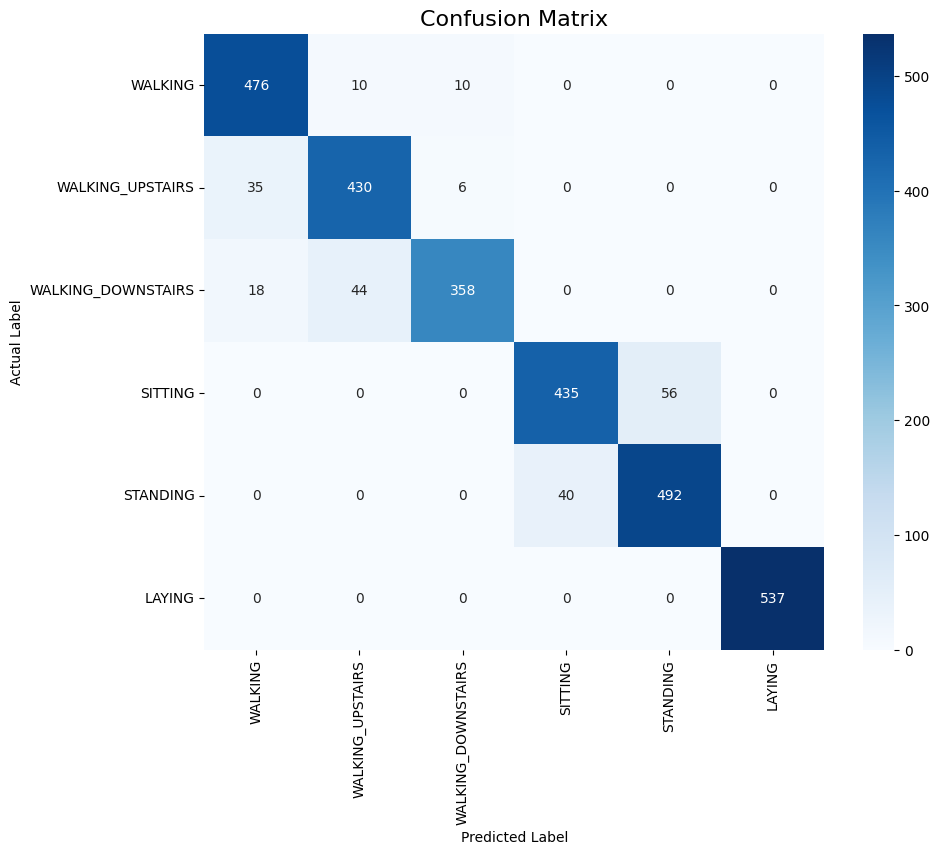

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test['activity_id'], y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=activity_labels['activity_name'],
            yticklabels=activity_labels['activity_name'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()